## NYC Taxi Fare Prediction ##

### Part 1: Import and Set Data ###

In [1]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import calendar
from math import sin, cos, sqrt, atan2, radians,asin
import folium
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
from folium.plugins import TimestampedGeoJson
from folium.plugins import MarkerCluster
from geopy.distance import great_circle
import matplotlib.dates as mdates
import matplotlib as mpl
from datetime import timedelta
import datetime as dt
from taxi_functions import distance, boundaryBox, isLocation

% matplotlib inline
plt.style.use('seaborn-whitegrid')

We will start by uploading a portion of the train dataset to explore. The full dataset consists of ~55M samples. We will begin with 3M. 

In [2]:
# Read training data into pandas dataframe

df_train = pd.read_csv('all/train.csv', nrows = 3000000, parse_dates=["pickup_datetime"])

# list first few rows
df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1


Let's examine what datatypes we'll be working with:

In [3]:
df_train.dtypes

key                          object
fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

What are the ranges of values for each of our feature spaces?

In [4]:
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,3.000000e+06,3.000000e+06,3.000000e+06,2.999977e+06,2.999977e+06,3.000000e+06
mean,1.134246e+01,-7.250894e+01,3.992033e+01,-7.250740e+01,3.991728e+01,1.684528e+00
std,9.828907e+00,1.320223e+01,8.644440e+00,1.308827e+01,9.984419e+00,1.329084e+00
min,-6.200000e+01,-3.426609e+03,-3.488080e+03,-3.408430e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073492e+01,-7.399139e+01,4.073402e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075315e+01,1.000000e+00
75%,1.250000e+01,-7.396710e+01,4.076712e+01,-7.396367e+01,4.076811e+01,2.000000e+00
max,1.273310e+03,3.439426e+03,2.912465e+03,3.457622e+03,3.345917e+03,2.080000e+02


A few observations from the data description:

* The minimum of the ```fare_amount``` feature is negative. As this is not realistic, I will drop those samples from the dataset.
* Some of the longitude/latitude coordinates are way off. We'll make a bounding box later and drop those as well.

### Break Datetime into year, day, hour features, etc. ###

In [5]:
# Convert pickup_datetime to a DateTime object
df_train['pickup_datetime']=pd.to_datetime(df_train['pickup_datetime'],format='%Y-%m-%d %H:%M:%S UTC')

# Create datetime features based on pickup_datetime
df_train['pickup_date'] = df_train['pickup_datetime'].dt.date
df_train['pickup_day'] = df_train['pickup_datetime'].apply(lambda x:x.day)
df_train['pickup_hour'] = df_train['pickup_datetime'].apply(lambda x:x.hour)
df_train['pickup_day_of_week'] = df_train['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
df_train['pickup_month'] = df_train['pickup_datetime'].apply(lambda x:x.month)
df_train['pickup_year'] = df_train['pickup_datetime'].apply(lambda x:x.year)

Check for missing values

In [6]:
df_train[pd.isnull(df_train)].sum()

key                   0.0
fare_amount           0.0
pickup_datetime       0.0
pickup_longitude      0.0
pickup_latitude       0.0
dropoff_longitude     0.0
dropoff_latitude      0.0
passenger_count       0.0
pickup_date           0.0
pickup_day            0.0
pickup_hour           0.0
pickup_day_of_week    0.0
pickup_month          0.0
pickup_year           0.0
dtype: float64

No missing values in the data.

## Part 2: Data Exploration, Cleaning, Feature Generation ##

#### Distribution of ```fare_amount``` ####

Text(0.5,1,'Distribution of fare_amount')

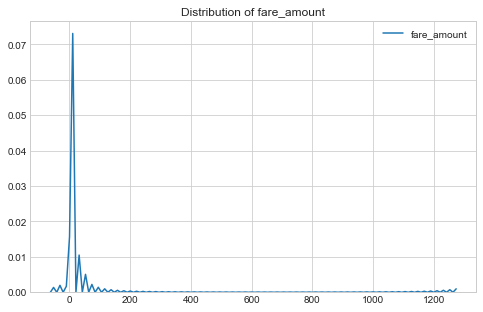

In [7]:
plt.figure(figsize=(8,5))
sns.kdeplot(df_train['fare_amount']).set_title("Distribution of fare_amount")

Observations:
    * There are negative values in the data
    * Data is also skewed

In [8]:
df_train.loc[df_train['fare_amount']<=0].shape

(200, 14)

There are 200 records with negative ```fare_amount```. We remove these records from the data.

In [9]:
df_train = df_train.loc[df_train['fare_amount']>0]
df_train.shape

(2999800, 14)

Since the ```fare_amount``` data is skewed, let us take the log transformation of the fare amount and plot the new distribution.

In [10]:
df_train['log_fare_amount'] = np.log(df_train['fare_amount'])

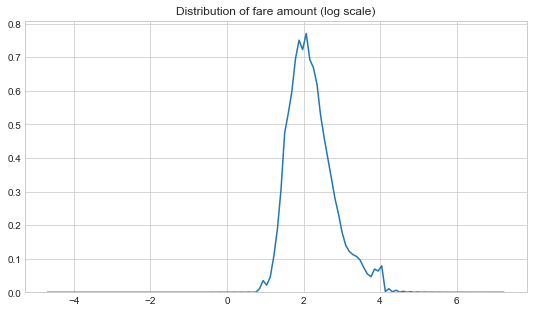

In [11]:
plt.figure(figsize=(9,5))
sns.kdeplot(df_train['log_fare_amount'].values).set_title("Distribution of fare amount (log scale)");

#### Heatmaps of Pickups and Dropoffs in NYC ####

Since we're working with location data, I'm going to plot the coordinates of the taxi rides on a map. 

Some helpful tools for this are:

* Easy to use map and GPS tool: https://www.gps-coordinates.net/
* Calculate distance between locations: https://www.travelmath.com/flying-distance/
* Open street map to grab using bouding box a map: https://www.openstreetmap.org/export#map=8/52.154/5.295

We can define a bounding box using the minimum and maximum coordinates for latitude and longitude from the test set. As such our trained model will account for the full coordinate range in our test set.

#### Distribution of pickup and dropoff lat/lng ####

In [12]:
# Range of pickup latitude
print("Range of pickup latitude: ", min(df_train['pickup_latitude']), max(df_train['pickup_latitude']))

# Range of dropoff latitude
print("Range of dropoff latitude: ", min(df_train['dropoff_latitude']), max(df_train['dropoff_latitude']))

# Range of pickup longitude
print("Range of pickup longitude: ", min(df_train['pickup_longitude']), max(df_train['pickup_longitude']))

# Range of dropoff longitude
print("Range of dropoff longitude: ", min(df_train['dropoff_longitude']), max(df_train['dropoff_longitude']))

Range of pickup latitude:  -3488.079513 2912.464657
Range of dropoff latitude:  -3488.079513 3345.9173530000003
Range of pickup longitude:  -3426.60895 3439.425565
Range of dropoff longitude:  -3408.4304979999997 3457.62235


The lat/lng center for New York City is ~(40, -74). There are lots of outlier locations based on these max/min values.

Let's read the test data and see what our boundaries are. 

In [47]:
df_test = pd.read_csv('./all/test.csv')
df_test.head(5)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [48]:
# Longitude and Latitude boundaries in test set
print("Longitude boundary in test set: %f %f" % (min(df_test.pickup_longitude.min(), df_test.dropoff_longitude.min()), max(df_test.pickup_longitude.max(), df_test.dropoff_longitude.max())))
print("Latitude boundary in test set: %f %f" % (min(df_test.pickup_latitude.min(), df_test.dropoff_latitude.min()), max(df_test.pickup_latitude.max(), df_test.dropoff_latitude.max())))

Longitude boundary in test set: -74.263242 -72.986532
Latitude boundary in test set: 40.568973 41.709555


We will set the boundary latitude/longitude coordinates based on the boundaries found in the test set. We will remove outlier locations for further analysis.

In [49]:
# lat/long boundaries present in the test set 
nyc_rides = {
    'min_lng':-74.263242,
    'min_lat':40.568973,
    'max_lng':-72.986532,
    'max_lat':41.709555
}

In [72]:
# Map boundary boxes
BB= {
    'min_lng':-74.22,
    'min_lat':40.55,
    'max_lng':-73.65,
    'max_lat':41
}

BB_zoom = {
    'min_lng':-74.1,
    'min_lat':40.6,
    'max_lng':-73.7,
    'max_lat':40.9
}

BB_zoom_2 = {
    'min_lng':-74,
    'min_lat':40.7,
    'max_lng':-73.95,
    'max_lat':40.8
}

In [38]:
# Eliminate samples with latitude/longitude coordinates outside NYC boundary
def boundary_box(df, BB):
    return (df.pickup_longitude >= BB['min_lng']) & (df.pickup_longitude <= BB['max_lng']) & \
           (df.pickup_latitude >= BB['min_lat']) & (df.pickup_latitude <= BB['max_lat']) & \
           (df.dropoff_longitude >= BB['min_lng']) & (df.dropoff_longitude <= BB['max_lng']) & \
           (df.dropoff_latitude >= BB['min_lat']) & (df.dropoff_latitude <= BB['max_lat'])

In [39]:
train_nyc = df_train[boundary_box(df_train, nyc_rides)]
train_nyc.shape

(2935682, 15)

In [57]:
# Using small datapoints, the streetgrid of New York becomes visible

def plot_hires(df, BB, figsize=(12, 12), ax=None, c=('r', 'b'), s = 0.005, alpha = 0.5):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    idx = boundary_box(df, BB)
    ax.scatter(df[idx].pickup_longitude, df[idx].pickup_latitude, c=c[0], s=s, alpha=alpha)
    ax.scatter(df[idx].dropoff_longitude, df[idx].dropoff_latitude, c=c[1], s=s, alpha=alpha)

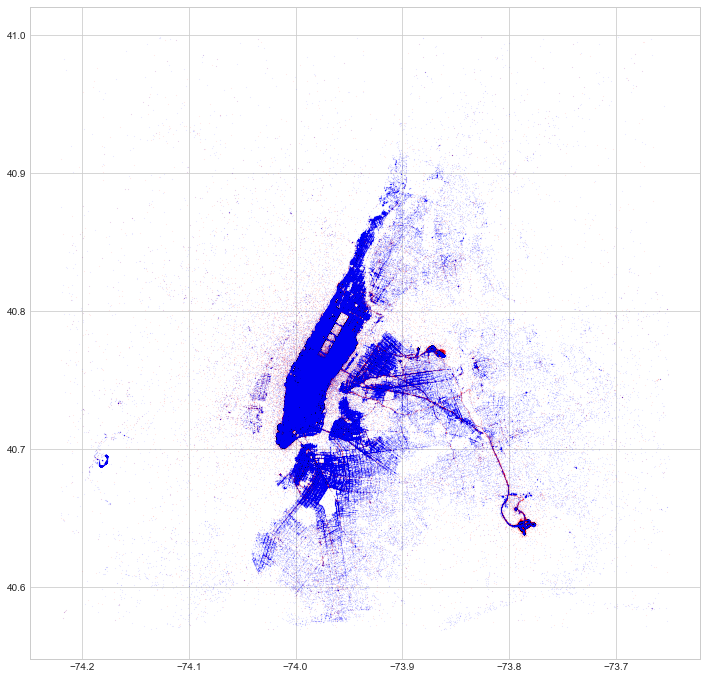

In [71]:
# Plot zoomed out
plot_hires(train_nyc, BB, s = 0.01, alpha = 0.3)

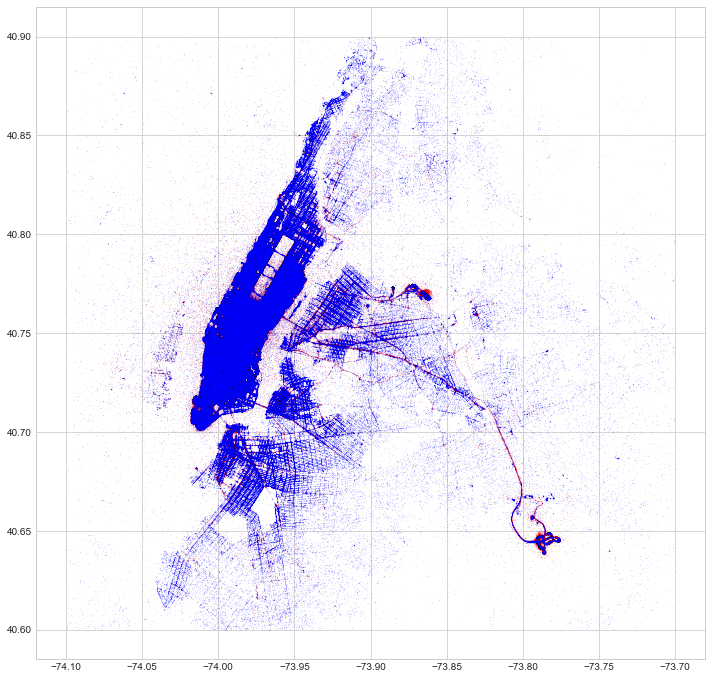

In [74]:
# First level zoom
plot_hires(train_nyc, BB_zoom)

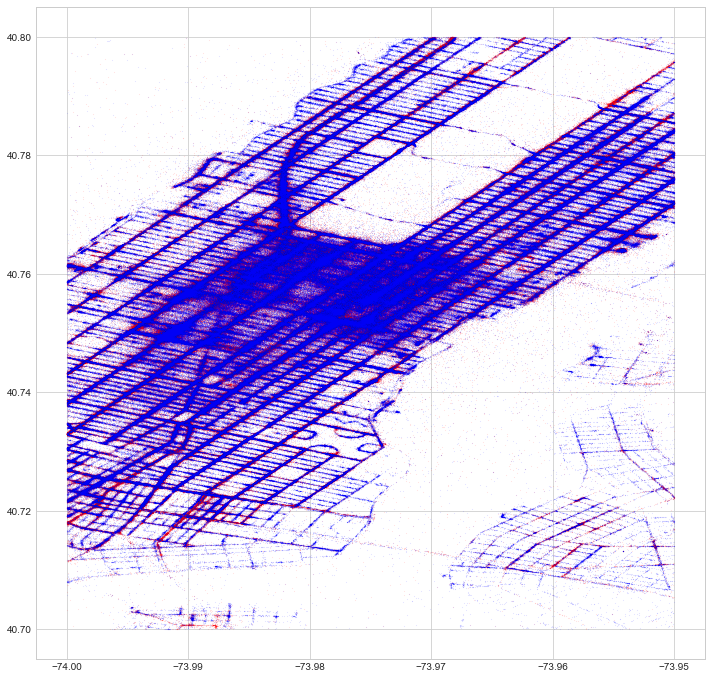

In [75]:
# Street-level zoom
plot_hires(train_nyc, BB_zoom_2)

## Intuitions ##

Intuitions on what features will impact fare:
    * Distance and fare positively correlated 
    * Passenger count and fare positively correlated
    * Fixed rate trips (airport trips) will have impact
    * Fares based on day of week / time of day / possibly year will impact fare

### Distance ###

In [87]:
# Distance intuition: longer the trip, higher the fare.

# Haversine distance 
def distance(lat1, lat2, lon1,lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

In [108]:
# Add trip distance feature to dataset
# NOTE: This feature is slightly misleading as our haversine distance formula will calculate the 
# direct distance between two points, not the shortest driving distance (longer). For future work,
# a solution to this could be using the Google Maps API to calculate the shortest driving distance between
# two points for each sample, and add that as a feature to the dataset. 
train_nyc['trip_distance'] = train_nyc.apply(lambda row: distance(row.loc[('pickup_latitude')], row.loc[('dropoff_latitude')], row.loc[('pickup_longitude')], row.loc[('dropoff_longitude')]), axis = 1)

# row['pickup_latitude'],row['dropoff_latitude'],row['pickup_longitude'],row['dropoff_longitude']),axis=1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [109]:
train_nyc.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,pickup_day,...,pickup_day_of_week,pickup_month,pickup_year,log_fare_amount,trip_distance,log_trip_distance,is_pickup_JFK,is_dropoff_JFK,is_pickup_EWR,is_dropoff_EWR
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15,15,...,Monday,6,2009,1.504077,0.640487,-0.445526,0,0,0,0
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05,5,...,Tuesday,1,2010,2.827314,5.250670,1.658356,0,0,0,0
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-18,18,...,Thursday,8,2011,1.740466,0.863411,-0.146865,0,0,0,0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21,21,...,Saturday,4,2012,2.041220,1.739386,0.553532,0,0,0,0
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09,9,...,Tuesday,3,2010,1.667707,1.242218,0.216899,0,0,0,0


Text(0.5,1,'Distribution of Trip Distance')

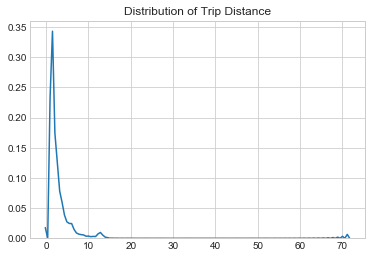

In [110]:
# Graph of trip distances
sns.kdeplot(train_nyc['trip_distance'].values).set_title("Distribution of Trip Distance")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0.5,1,'Distribution of Trip Distance')

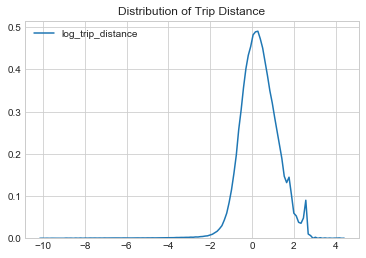

In [111]:
# Log transform trip distance to improve distribution for modeling.
train_nyc['log_trip_distance'] = np.log(train_nyc.loc[:,'trip_distance'])

# Graph of trip distances (log scale)
sns.kdeplot(train_nyc.loc[:,'log_trip_distance']).set_title("Distribution of Trip Distance")

Text(0.5,1,'Trip distance vs. fare amount')

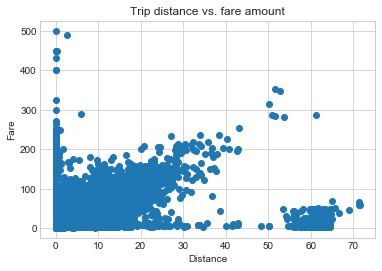

In [112]:
# Plot distances and fares

plt.scatter(x=train_nyc['trip_distance'], y=train_nyc['fare_amount'])
plt.xlabel("Distance")
plt.ylabel("Fare")
plt.title("Trip distance vs. fare amount")

### Airport Trips ###

In [97]:
# Coordinates for NYC Airports
# Source: https://www.coordinatesfinder.com/

    
JFK:{
    'min_lng':-73.8352,
    'min_lat':40.6195,
    'max_lng':-73.7401, 
    'max_lat':40.6659
}
              
EWR:{
    'min_lng':-74.1925,
    'min_lat':40.6700, 
    'max_lng':-74.1531, 
    'max_lat':40.7081 

}

LGA:{
    'min_lng':-73.8895, 
    'min_lat':40.7664, 
    'max_lng':-73.8550, 
    'max_lat':40.7931    
}
    


def isAirport(lat, lng, airport_name):
    
    if lat>=nyc_airports[airport_name]['min_lat'] and lat<=nyc_airports[airport_name]['max_lat'] and lng>=nyc_airports[airport_name]['min_lng'] and lng<=nyc_airports[airport_name]['max_lng']:
        return 1
    else:
        return 0
        

In [99]:
# Add Features for Airport dropoffs and pickups

train_nyc['is_pickup_JFK']=train_nyc.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'JFK'),axis=1)
train_nyc['is_dropoff_JFK']=train_nyc.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'JFK'),axis=1)
train_nyc['is_pickup_EWR']=train_nyc.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'EWR'),axis=1)
train_nyc['is_dropoff_EWR']=train_nyc.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'EWR'),axis=1)
train_nyc['is_pickup_LGA']=train_nyc.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'LGA'),axis=1)
train_nyc['is_dropoff_LGA']=train_nyc.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'LGA'),axis=1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-99-7a9a7bdd8b98>", line 4, in <module>
    train_nyc['is_dropoff_JFK']=train_nyc.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'JFK'),axis=1)
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py", line 4877, in apply
    ignore_failures=ignore_failures)
  File "/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py", line 4974, in _apply_standard
    keys.append(v.name)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 1863, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During h

KeyboardInterrupt: 

### Passenger Count ###

In [37]:
df_train.groupby('passenger_count')['distance_miles', 'fare_amount'].mean()

,distance_miles,fare_amount
passenger_count,,
0,1.732107,8.813325
1,2.040213,11.203137
2,2.179451,11.800116
3,2.100560,11.519038
4,2.132063,11.720811
5,2.072248,11.216309
6,2.122724,12.169241
9,8.106351,104.000000


In [38]:
print("Average $USD/Mile : {:0.2f}".format(df_train.fare_amount.sum()/df_train.distance_miles.sum()))

Average $USD/Mile : 5.48


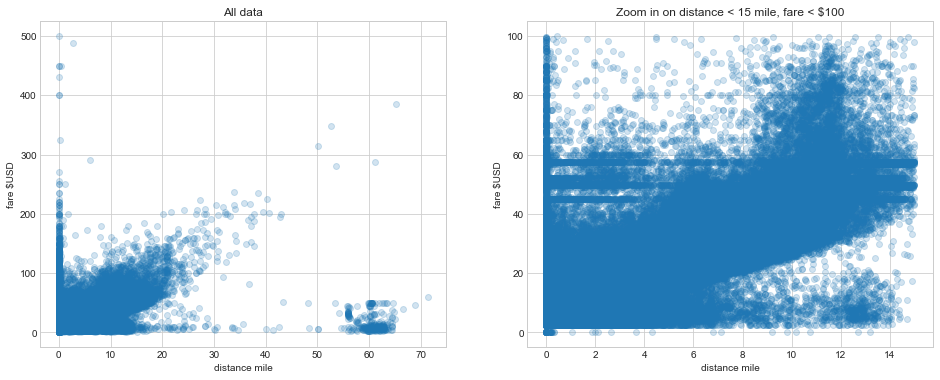

In [39]:
# scatter plot distance - fare
fig, axs = plt.subplots(1, 2, figsize=(16,6))
axs[0].scatter(df_train.distance_miles, df_train.fare_amount, alpha=0.2)
axs[0].set_xlabel('distance mile')
axs[0].set_ylabel('fare $USD')
axs[0].set_title('All data')

# zoom in on part of data
idx = (df_train.distance_miles < 15) & (df_train.fare_amount < 100)
axs[1].scatter(df_train[idx].distance_miles, df_train[idx].fare_amount, alpha=0.2)
axs[1].set_xlabel('distance mile')
axs[1].set_ylabel('fare $USD')
axs[1].set_title('Zoom in on distance < 15 mile, fare < $100');

In [47]:
# remove datapoints with distance <0.05 miles
idx = (df_train.distance_miles >= 0.05)
print('Old size: %d' % len(df_train))
df_train = df_train[idx]
print('New size: %d' % len(df_train))

Old size: 1957918
New size: 1926612


## Fixed Fee Trips ##

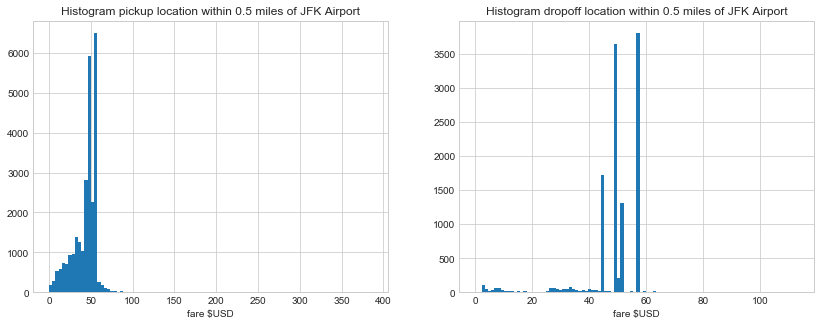

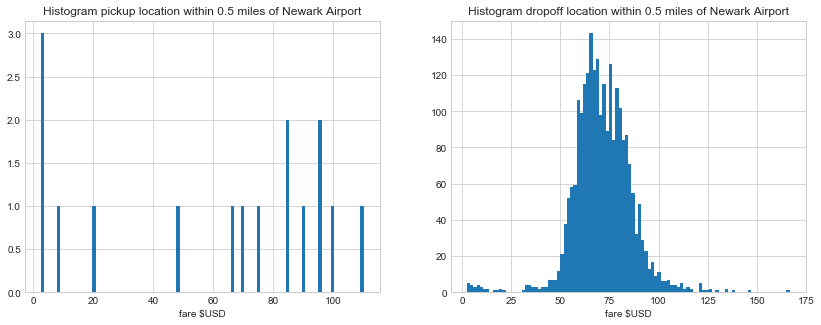

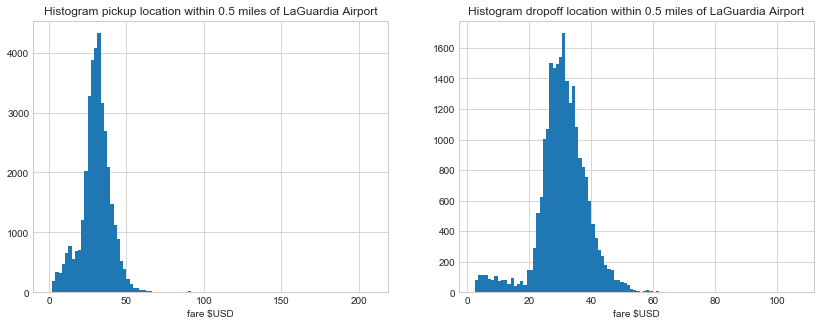

In [48]:
# JFK airport coordinates, see https://www.travelmath.com/airport/JFK
jfk = (-73.7822222222, 40.6441666667)
nyc = (-74.0063889, 40.7141667)
ewr = (-74.175, 40.69) # Newark Liberty International Airport, see https://www.travelmath.com/airport/EWR
lgr = (-73.87, 40.77) # LaGuardia Airport, see https://www.travelmath.com/airport/LGA


def plot_location_fare(loc, name, range=0.5):
    # select all datapoints with dropoff location within range of airport
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    idx = (distance(df_train.pickup_latitude, df_train.pickup_longitude, loc[1], loc[0]) < range)
    df_train[idx].fare_amount.hist(bins=100, ax=axs[0])
    axs[0].set_xlabel('fare $USD')
    axs[0].set_title('Histogram pickup location within {} miles of {}'.format(range, name))

    idx = (distance(df_train.dropoff_latitude, df_train.dropoff_longitude, loc[1], loc[0]) < range)
    df_train[idx].fare_amount.hist(bins=100, ax=axs[1])
    axs[1].set_xlabel('fare $USD')
    axs[1].set_title('Histogram dropoff location within {} miles of {}'.format(range, name));
    
plot_location_fare(jfk, 'JFK Airport')
plot_location_fare(ewr, 'Newark Airport')
plot_location_fare(lgr, 'LaGuardia Airport')

Some relevant information regarding NYC Taxi pricing:

* Initial charge for most rides (excluding from JFK and other airports) is $2.50 upon entry. * After that there $0.5 every unit where the unit is defined as 1/5th of a mile or when the Taxicab is travelling 12 Miles an hour or more...since we can't decipher the velocity of the car, I would take 1/5th of a mile as the unit and convert the distance into this unit.
* $0.5 of additional surcharge between 8PM - 6AM.
* Peak hour weekday surcharge of $1 Monday-Friday between 4PM-8PM.
* There is a $0.5 MTA State Surcharge for all trips that end in New York City or Nassau, Suffolk, Westchester, Rockland, Dutchess, Orange or Putnam Counties.
* There is a $0.3 Improvement surcharge

**Note an error in these calculations is the distance in our dataset is linear point-to-point. In reality, the distance measured by the road is longer.**

## Fare at Night vs. Day ##

In [49]:
df_train['fare_per_mile'] = df_train.fare_amount / df_train.distance_miles
df_train.fare_per_mile.describe()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


count    1.926612e+06
mean     7.421234e+00
std      1.231703e+01
min      0.000000e+00
25%      4.770420e+00
50%      6.133938e+00
75%      8.086521e+00
max      3.812572e+03
Name: fare_per_mile, dtype: float64

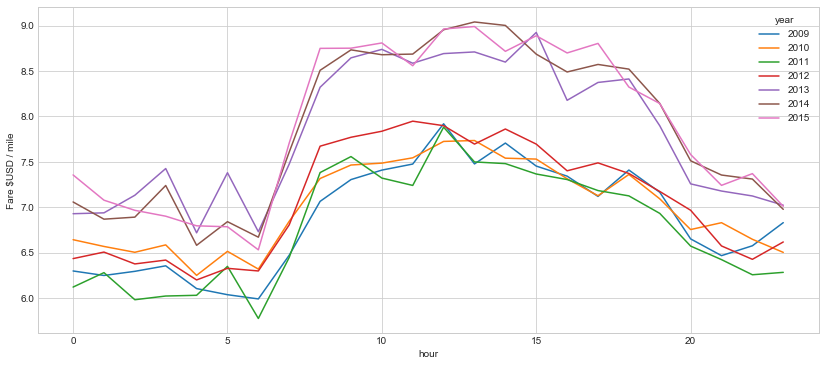

In [50]:
# display pivot table
df_train.pivot_table('fare_per_mile', index='hour', columns='year').plot(figsize=(14,6))
plt.ylabel('Fare $USD / mile');

## Baseline Model ##

In [51]:
# define dataset
df_train = df_train[df_train.passenger_count != 0]
features = ['year', 'hour', 'distance_miles', 'passenger_count']
X = df_train[features].values
y = df_train['fare_amount'].values

In [52]:
X.shape, y.shape

((1919725, 4), (1919725,))

In [53]:
# error functions
from sklearn.metrics import mean_squared_error, explained_variance_score

def plot_prediction_analysis(y, y_pred, figsize=(10,4), title=''):
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    axs[0].scatter(y, y_pred)
    mn = min(np.min(y), np.min(y_pred))
    mx = max(np.max(y), np.max(y_pred))
    axs[0].plot([mn, mx], [mn, mx], c='red')
    axs[0].set_xlabel('$y$')
    axs[0].set_ylabel('$\hat{y}$')
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    evs = explained_variance_score(y, y_pred)
    axs[0].set_title('rmse = {:.2f}, evs = {:.2f}'.format(rmse, evs))
    
    axs[1].hist(y-y_pred, bins=50)
    avg = np.mean(y-y_pred)
    std = np.std(y-y_pred)
    axs[1].set_xlabel('$y - \hat{y}$')
    axs[1].set_title('Histrogram prediction error, $\mu$ = {:.2f}, $\sigma$ = {:.2f}'.format(avg, std))
    
    if title!='':
        fig.suptitle(title)

In [56]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

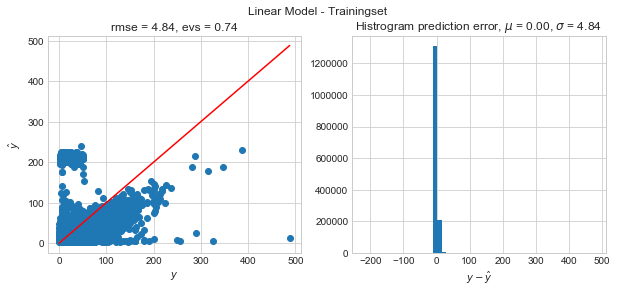

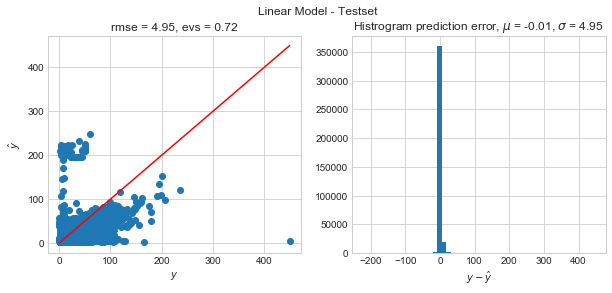

In [57]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

model_lin = Pipeline((
        ("standard_scaler", StandardScaler()),
        ("lin_reg", LinearRegression()),
    ))
model_lin.fit(X_train, y_train)

y_train_pred = model_lin.predict(X_train)
plot_prediction_analysis(y_train, y_train_pred, title='Linear Model - Trainingset')

y_test_pred = model_lin.predict(X_test)
plot_prediction_analysis(y_test, y_test_pred, title='Linear Model - Testset')